<a href="https://colab.research.google.com/github/PanagiotisPetrid/ASTRO-BEAM-PanagiotisPetridis/blob/main/Localized_Classification_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Necessary dependencies / libraries

In [1]:
#Run this block to import the necessary dependencies
!pip install torch torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import curve_fit
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#Denoising Autoencoder (DAE)

##Create the training dataset

###Comments

Explaining the comments and the choices made in the code:
- `# Convert to PyTorch tensors` - A torch.tensor is a multi-dimensional matrix containing elements of a single data type. We convert the data into a PyTorch tensor in order to feed this data into PyTorch models, such as our autoencoder, and use it for forward passes, training, and evaluation.
- `torch.float32` - It means that each element in the tensor will be stored as a 32-bit floating point number (a common data type for numeric operations in neural networks).
It ensures that the data is in a format suitable for floating-point computations, which is critical for training neural networks in PyTorch since most deep learning operations work with floating point numbers.
- `# Batch size` - Batch size is a hyperparameter that defines the number of samples for the autoencoder to work through before updating internal model parameters

###Code

<ipython-input-2-918e7715e971>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signals_tensor = torch.tensor(signals, dtype=torch.float32)


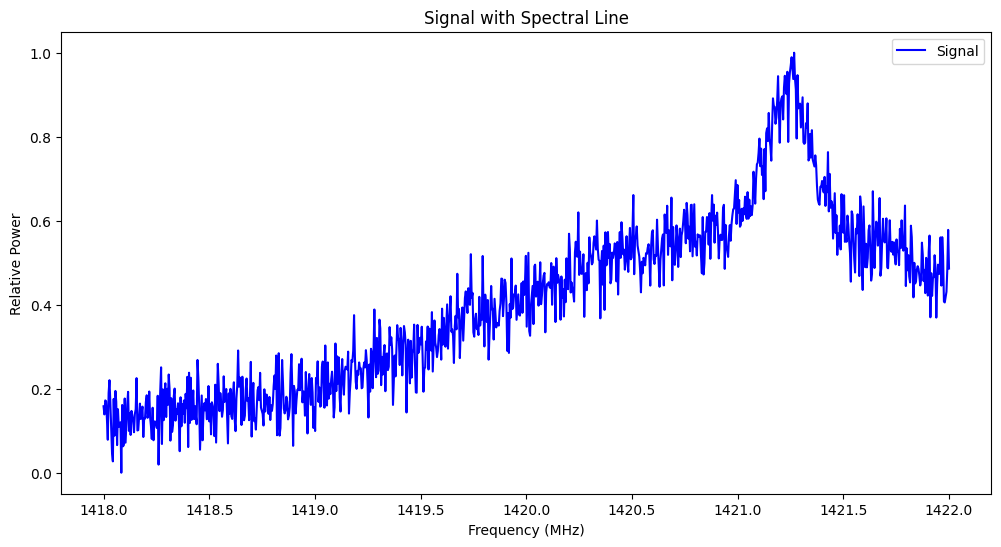

In [2]:
# Define a function to generate a background-only signal (without spectral line)
def generate_background_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    # Random background signal generation
    signal = (np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
              np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range))
    # Add random Gaussian noise
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    # Normalize the signal
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Define a function to generate a signal with a spectral line
def generate_signal_with_spectral_line(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    # Add randomness to the background signal generation
    signal = (np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
              np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range))
    # Add the spectral line at a random frequency
    signal += np.random.uniform(0.9, 1.5) * np.exp(-0.5 * ((freq_range - np.random.uniform(1418.5, 1421.5)) / 0.1)**2)
    # Add random Gaussian noise
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    # Normalize the signal
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Signal parameters
n_samples = 1000  # Number of sample points in each signal
freq_range = np.linspace(1418, 1422, n_samples)  # Frequency range
n_signals = 3000  # Total number of signals to generate
signals_fraction = n_signals // 2 # Number of signals WITHOUT spectral lines

# Generate half signals with spectral lines and half without
signals = []
labels = []

# Generate background-only signals
for _ in range(signals_fraction):
    signals.append(generate_background_signal(n_samples))
    labels.append(0)  # Label for background-only

# Generate signals with spectral lines
for _ in range(n_signals - signals_fraction):
    signals.append(generate_signal_with_spectral_line(n_samples))
    labels.append(1)  # Label for signal with spectral line

# Convert to PyTorch tensors
signals_tensor = torch.tensor(signals, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create a DataLoader for batching
dataset = TensorDataset(signals_tensor, labels_tensor)
batch_size = 64  # Batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot a sample signal
sample_signal = generate_signal_with_spectral_line(n_samples)
plt.figure(figsize=(12, 6))
plt.plot(freq_range, sample_signal, label='Signal', color='blue')
plt.title('Signal with Spectral Line')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

##Define the DAE

###Comments

Comments:
- `nn.Module` is the base class for all neural networks in PyTorch.
- `ReLU (nn.ReLU())` - This is a popular activation function that introduces non-linearity into the model (Activation functions are essential in neural networks as they determine the output of a node given an input or set of inputs). It helps to handle complex data distributions and makes the model more powerful. The **Rectified Linear Unit** (ReLU) is one of the most widely used activation functions in deep learning. The ReLU function is defined as: **ReLU(x) = max(0, x)**. This means that if the input x is positive, the output will be x. If the input x is negative, the output will be 0.
- `nn.Linear(n_samples, 512)` - The first layer takes in the input (which has n_samples data points) and reduces it to 512 neurons.
- `nn.Linear(512, 128)` - This second layer further compresses the 512 neurons down to 128 neurons.
- `nn.Linear(128, 32)` - The final layer compresses the 128 neurons down to 32 neurons, which is the **latent space representation**. This is where the most significant compression occurs.
- `nn.Tanh()` -  [DEPRECATED]  We use the **tanh** activation function, so that our values are between -1 and 1.

- `nn.Sigmoid()` - The **sigmoid activation function** outputs values between 0 and 1. It introduces non-linearity and is particularly useful for making sure the output remains within a specific range.

###Code

In [3]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_samples, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        # Decoder with Tanh for negative values
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, n_samples),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the DAE model
dae = DenoisingAutoencoder()

# Print the model architecture
print(dae)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1000, bias=True)
    (3): Sigmoid()
  )
)


##Define the training loop

###Comments

We then have to define the **loss function** and the **optimizer** we will use in our autoencoder, in order to create the training loop.
 - For the **loss function** we use the **Mean Squared Error** function, a popular loss function used in regression tasks that measures the average squared differences between predicted and actual values.
 - For the **optimizer** we use the **ADAM optimizer**. Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm.

We have to consider the **number of epochs** for the best training of the autoencoder. Generally speaking, the number of epochs will change if the dataset is bigger.
 - The number of epochs should not be decided a-priori. We should run the training and monitor the training and validation losses over time and stop training when the validation loss reaches a plateau or starts increasing. This technique is called "**early stopping**" and is a good practice in machine learning.


###Code

Epoch [1/50], Loss: 0.0103
Epoch [2/50], Loss: 0.0113
Epoch [3/50], Loss: 0.0106
Epoch [4/50], Loss: 0.0089
Epoch [5/50], Loss: 0.0089
Epoch [6/50], Loss: 0.0080
Epoch [7/50], Loss: 0.0085
Epoch [8/50], Loss: 0.0080
Epoch [9/50], Loss: 0.0080
Epoch [10/50], Loss: 0.0080
Epoch [11/50], Loss: 0.0063
Epoch [12/50], Loss: 0.0064
Epoch [13/50], Loss: 0.0073
Epoch [14/50], Loss: 0.0062
Epoch [15/50], Loss: 0.0067
Epoch [16/50], Loss: 0.0065
Epoch [17/50], Loss: 0.0058
Epoch [18/50], Loss: 0.0060
Epoch [19/50], Loss: 0.0052
Epoch [20/50], Loss: 0.0059
Epoch [21/50], Loss: 0.0058
Epoch [22/50], Loss: 0.0054
Epoch [23/50], Loss: 0.0051
Epoch [24/50], Loss: 0.0051
Epoch [25/50], Loss: 0.0057
Epoch [26/50], Loss: 0.0049
Epoch [27/50], Loss: 0.0049
Epoch [28/50], Loss: 0.0046
Epoch [29/50], Loss: 0.0050
Epoch [30/50], Loss: 0.0049
Epoch [31/50], Loss: 0.0051
Epoch [32/50], Loss: 0.0052
Epoch [33/50], Loss: 0.0053
Epoch [34/50], Loss: 0.0050
Epoch [35/50], Loss: 0.0051
Epoch [36/50], Loss: 0.0049
E

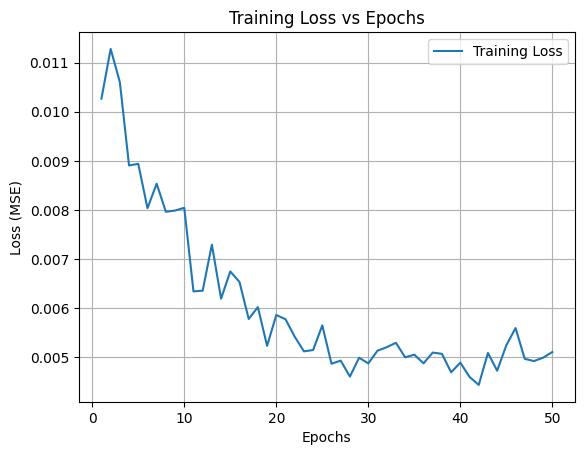

In [4]:
# Loss function (Mean Squared Error) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dae.parameters(), lr=0.001)

# Noise generation for corrupting the input
def add_noise(signal, noise_level=0.1):
    noise = torch.normal(0, noise_level, signal.shape)
    noisy_signal = signal + noise
    return noisy_signal

# Number of epochs
n_epochs = 50

# List to store the loss values for each epoch
loss_values = []

for epoch in range(n_epochs):
    for data in dataloader:
        clean_signals = data[0]  # Get the clean signals batch

        # Corrupt the clean signals with noise
        noisy_signals = add_noise(clean_signals)

        # Forward pass: autoencoder's prediction from noisy signals
        reconstructed_signals = dae(noisy_signals)

        # Compute the loss (reconstruction error) between the original clean signal and the reconstructed signal
        loss = criterion(reconstructed_signals, clean_signals) # Using clean_signals yields much lower loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store the loss for each epoch
    loss_values.append(loss.item())

    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot the loss versus epochs
plt.plot(range(1, n_epochs + 1), loss_values, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

##Autoencoder testing and results visualization

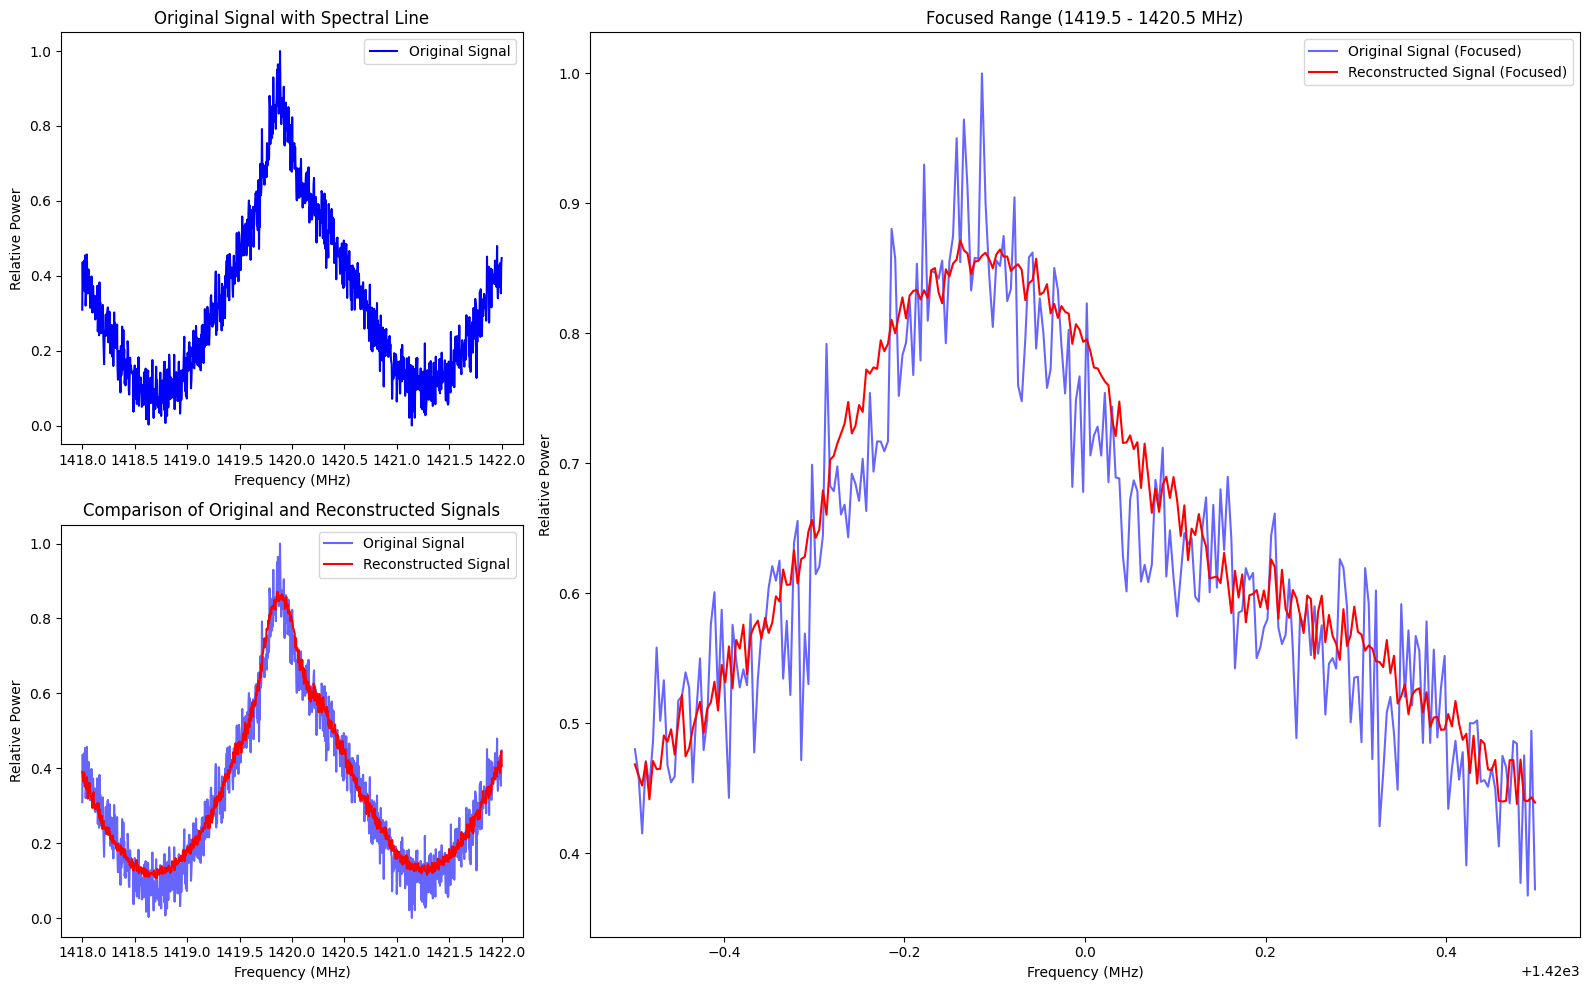

In [6]:
# Test the autoencoder with a sample signal
sample_signal = generate_signal_with_spectral_line(n_samples)
sample_signal_tensor = torch.tensor(sample_signal, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Pass the signal through the autoencoder
with torch.no_grad():
    reconstructed_signal = dae(sample_signal_tensor).squeeze(0).numpy()

# Define the focus range for a specific frequency range
focus_range_mask = (freq_range >= 1419.5) & (freq_range <= 1420.5)
focused_freq_range = freq_range[focus_range_mask]
focused_clean_signal = sample_signal[focus_range_mask]
focused_reconstructed_signal = reconstructed_signal[focus_range_mask]

# Create the subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Upper left plot: Original Signal with Spectral Line
axs[0, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue')
axs[0, 0].set_title('Original Signal with Spectral Line')
axs[0, 0].set_xlabel('Frequency (MHz)')
axs[0, 0].set_ylabel('Relative Power')
axs[0, 0].legend()

# Lower left plot: Comparison of Noisy and Reconstructed Signal
axs[1, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue', alpha=0.6)  # Plot the original signal
axs[1, 0].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red')
axs[1, 0].set_title('Comparison of Original and Reconstructed Signals')
axs[1, 0].set_xlabel('Frequency (MHz)')
axs[1, 0].set_ylabel('Relative Power')
axs[1, 0].legend()

# Focused plot in the middle and right of the grid (spanning both rows)
ax_focus = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
ax_focus.plot(focused_freq_range, focused_clean_signal, label='Original Signal (Focused)', color='blue', alpha=0.6)
ax_focus.plot(focused_freq_range, focused_reconstructed_signal, label='Reconstructed Signal (Focused)', color='red')
ax_focus.set_title('Focused Range (1419.5 - 1420.5 MHz)')
ax_focus.set_xlabel('Frequency (MHz)')
ax_focus.set_ylabel('Relative Power')
ax_focus.legend()

# Hide unused subplot space
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[1, 1].axis('off')
axs[1, 2].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

#Localized Classification Neural Network (LCNN)

##Traning Dataset generation:

In [7]:
from scipy.signal import find_peaks

# Generate training dataset with regions
def generate_training_data(n_samples, n_regions, region_size):
    signals, labels = [], []
    for _ in range(n_regions):
        if np.random.rand() > 0.5:  # Region with spectral line
            signal = generate_signal_with_spectral_line(n_samples)
            peaks, _ = find_peaks(signal, height=0.8)
            if peaks.size > 0:
                peak_idx = np.random.choice(peaks)
                start = max(0, peak_idx - region_size // 2)
                end = min(n_samples, peak_idx + region_size // 2)
                region = signal[start:end]
                region = np.pad(region, (0, region_size - len(region)), mode='constant')
                signals.append(region)
                labels.append(1)
        else:  # Region without spectral line
            signal = generate_background_signal(n_samples)
            start = np.random.randint(0, n_samples - region_size)
            end = start + region_size
            signals.append(signal[start:end])
            labels.append(0)
    signals = np.array(signals)
    labels = np.array(labels)
    return signals, labels

## Define the LCNN

In [14]:
# Neural network for spectral line classification
class SpectralLineClassifier(nn.Module):
    def __init__(self):
        super(SpectralLineClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * 75, 64)  # Adjust according to region_size/2
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

print(SpectralLineClassifier)

# Parameters
n_samples = 1000
region_size = 200
n_regions = 5000
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<class '__main__.SpectralLineClassifier'>


## Define the training loop

In [17]:
# Training the classifier
def train_classifier(classifier, train_loader, device, epochs=30, lr=0.0001, patience=5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        classifier.train()
        epoch_loss = 0.0

        for signals_batch, labels_batch in train_loader:
            signals_batch = signals_batch.unsqueeze(1).to(device)
            labels_batch = labels_batch.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = classifier(signals_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

def classify_signal(signal, dae, classifier, region_size, device):
    # Preprocess the signal with the DAE
    dae.eval()
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed_signal = dae(signal_tensor).cpu().squeeze().numpy()

    # Find peaks in the reconstructed signal
    peaks, _ = find_peaks(reconstructed_signal, height=0.8)

    # Classify each region around a peak
    total_spectral_lines = 0
    for peak_idx in peaks:
        start = max(0, peak_idx - region_size // 2)
        end = min(len(signal), peak_idx + region_size // 2)
        region = reconstructed_signal[start:end]
        region = np.pad(region, (0, region_size - len(region)), mode='constant')
        region_tensor = torch.tensor(region, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        classifier.eval()
        with torch.no_grad():
            prediction = classifier(region_tensor)
            if prediction.item() > 0.5:
                total_spectral_lines += 1

    return total_spectral_lines, reconstructed_signal

def visualize_pipeline(signal, reconstructed_signal, total_spectral_lines):
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='Original Signal')
    plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--')
    plt.title(f"Total Spectral Lines Detected: {total_spectral_lines}")
    plt.legend()
    plt.show()

# Generate training data
signals, labels = generate_training_data(n_samples, n_regions, region_size)
train_dataset = TensorDataset(torch.tensor(signals, dtype=torch.float32),
                               torch.tensor(labels, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize and train classifier
classifier = SpectralLineClassifier().to(device)
train_classifier(classifier, train_loader, device)

Epoch [1/30], Loss: 0.6332
Epoch [2/30], Loss: 0.5002
Epoch [3/30], Loss: 0.4436
Epoch [4/30], Loss: 0.3955
Epoch [5/30], Loss: 0.3642
Epoch [6/30], Loss: 0.3407
Epoch [7/30], Loss: 0.3246
Epoch [8/30], Loss: 0.3148
Epoch [9/30], Loss: 0.3091
Epoch [10/30], Loss: 0.3028
Epoch [11/30], Loss: 0.3016
Epoch [12/30], Loss: 0.2991
Epoch [13/30], Loss: 0.2964
Epoch [14/30], Loss: 0.2944
Epoch [15/30], Loss: 0.2933
Epoch [16/30], Loss: 0.2874
Epoch [17/30], Loss: 0.2848
Epoch [18/30], Loss: 0.2866
Epoch [19/30], Loss: 0.2825
Epoch [20/30], Loss: 0.2823
Epoch [21/30], Loss: 0.2849
Epoch [22/30], Loss: 0.2793
Epoch [23/30], Loss: 0.2785
Epoch [24/30], Loss: 0.2800
Epoch [25/30], Loss: 0.2792
Epoch [26/30], Loss: 0.2796
Epoch [27/30], Loss: 0.2775
Epoch [28/30], Loss: 0.2773
Epoch [29/30], Loss: 0.2771
Epoch [30/30], Loss: 0.2758


##Test the LCNN

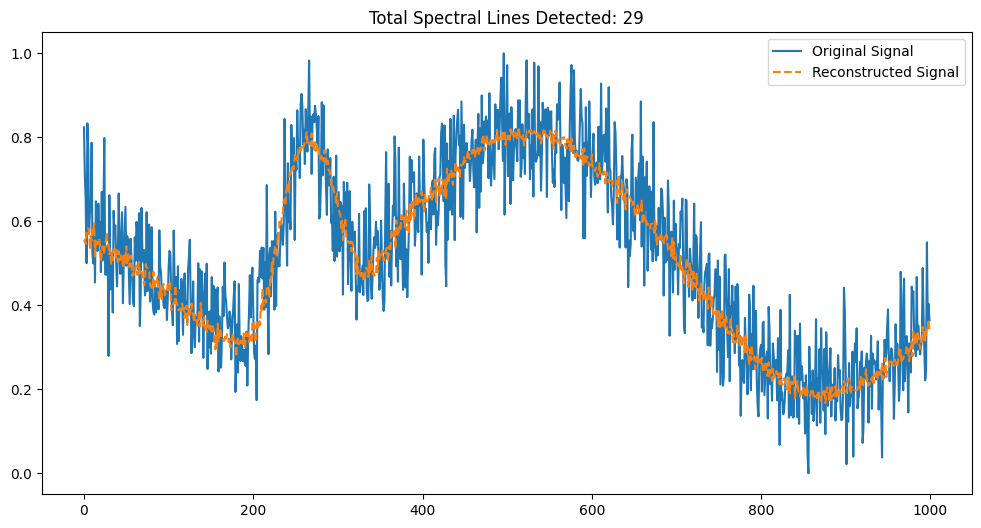

In [19]:
# Test the pipeline
if np.random.rand() > 0.5:
    test_signal = generate_signal_with_spectral_line(n_samples)
else:
    test_signal = generate_background_signal(n_samples)

total_lines, reconstructed_signal = classify_signal(test_signal, dae, classifier, region_size, device)
visualize_pipeline(test_signal, reconstructed_signal, total_lines)